In [51]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Reshape, LeakyReLU, Flatten

In [52]:
class GAN(keras.Model):
  def __init__(self):
    super(GAN, self).__init__()
    self.latent_dim = 128
    self.generator = self.build_gen()
    self.discriminator = self.build_disc()

  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(GAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn

  def train_step(self, real):
    batch_size = tf.shape(real)[0]
    noise = tf.random.normal([batch_size, self.latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = self.generator(noise, training=True)
      
      real_output = self.discriminator(real, training=True)
      fake_output = self.discriminator(generated_images, training=True)

      d_loss = self.loss_fn(tf.ones_like(real_output), real_output) + self.loss_fn(tf.zeros_like(fake_output), fake_output)
      g_loss = self.loss_fn(tf.ones_like(fake_output), fake_output)

    gradients_of_discriminator = disc_tape.gradient(d_loss, self.discriminator.trainable_weights)
    gradients_of_generator = gen_tape.gradient(g_loss, self.generator.trainable_weights)

    self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_weights))
    self.g_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_weights))
    
    return {"d_loss": d_loss, "g_loss": g_loss}

  def plot_images(self):
    seed = tf.random.normal([16, 128])
    predictions = self.generator(seed, training=False)
    print(type(predictions))

    fig, axs = plt.subplots(4, 4, figsize=(4,4))
    cnt = 0
    for i in range(4):
      for j in range(4):
        axs[i, j].imshow(predictions[cnt, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        cnt += 1
        plt.axis("off")
    plt.show()

  def build_disc(self):
    discriminator = keras.Sequential(
      [
        Flatten(input_shape=(28,28,1)),
        Dense(128),
        LeakyReLU(alpha=0.2),
        Dense(64),
        LeakyReLU(alpha=0.2),
        Dense(1)
      ],
      name="discriminator",
    )
    return discriminator

  
  def build_gen(self):
    generator = keras.Sequential(
    [
        keras.Input(shape=(128,)),
        Dense(128),
        LeakyReLU(alpha=0.2),
        Dense(256),
        LeakyReLU(alpha=0.2),
        Dense(28*28*1, activation="tanh"),
        Reshape((28,28,1))
    ],
      name="generator",
    )
    return generator

In [53]:
import numpy as np
gan = GAN()
(X_train, _), (_, _) = keras.datasets.mnist.load_data()
X_train = (X_train.astype("float32") - 127.5) / 127.5
X_train = np.reshape(X_train, (-1, 28,28,1))

In [54]:
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(buffer_size=1024).batch(64)

In [55]:
gan.compile(
  d_optimizer=keras.optimizers.Adam(learning_rate=3e-4),
  g_optimizer=keras.optimizers.Adam(learning_rate=3e-4),
  loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
)

In [56]:
gan.fit(dataset, epochs=100)

Epoch 1/100
  1/938 [..............................] - ETA: 6:13 - d_loss: 1.9057 - g_loss: 0.6115

2022-01-06 13:24:47.229822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 8s 8ms/step - d_loss: 0.1803 - g_loss: 3.1182
Epoch 2/100
938/938 [==============================] - 8s 8ms/step - d_loss: 0.5445 - g_loss: 2.3347
Epoch 3/100
938/938 [==============================] - 8s 8ms/step - d_loss: 0.9078 - g_loss: 1.6457
Epoch 4/100
938/938 [==============================] - 8s 8ms/step - d_loss: 1.0667 - g_loss: 1.3844
Epoch 5/100
938/938 [==============================] - 8s 8ms/step - d_loss: 0.8901 - g_loss: 1.6344
Epoch 6/100
938/938 [==============================] - 8s 8ms/step - d_loss: 1.1517 - g_loss: 1.4466
Epoch 7/100
938/938 [==============================] - 8s 8ms/step - d_loss: 1.1839 - g_loss: 1.3763
Epoch 8/100
938/938 [==============================] - 8s 8ms/step - d_loss: 1.0446 - g_loss: 1.5245
Epoch 9/100
938/938 [==============================] - 8s 8ms/step - d_loss: 0.9672 - g_loss: 1.5447
Epoch 10/100
938/938 [==============================] - 8s 8ms/step - d_loss: 0.8113 - g_loss: 1.7920
E

<class 'tensorflow.python.framework.ops.EagerTensor'>


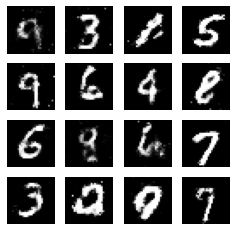

In [57]:
gan.plot_images()

In [58]:
gan.generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 784)               201488    
_________________________________________________________________
reshape_6 (Reshape)          (None, 28, 28, 1)         0         
Total params: 251,024
Trainable params: 251,024
Non-trainable params: 0
___________________________________________________

In [59]:
gan.discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 65        
Total params: 108,801
Trainable params: 108,801
Non-trainable params: 0
_______________________________________________